### Setting up a run

In [1]:
import validate as v
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_context('talk')
execfile("setup.py")

/home/ljw/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/ljw/.local/lib/python2.7/site-packages/ipykernel/__main__.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ljw/.local/lib/python2.7/site-packages/ipykernel/__main__.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ljw/.local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: coda

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/ljw/.local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: MASS

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/ljw/.local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: ##
## Markov Chain Mont

In [2]:
R("i<-2")
v.to_R(s.trace.Statics['rhos'],'detval')
v.to_R(s.trace.Statics['lambdas'], 'detvalM')

<Matrix - Python:0x7f318e63bb48 / R:0x557fcc619e20>
[-0.990000, -0.989000, -0.988000, ..., -33.787931, -34.307374, -34.865562]

In [3]:
%matplotlib inline
import seaborn as sb

First, I keep track of the "distance" between the results of the computation in R and in Python. Practically speaking, this means comparing the next draw's parameters computed in R and in Python for each iteration, $t$. 

To do this, though, we need to define a components used during the sampling:

$$\Delta : \text{matrix aggregating $n$ atoms into $j$ regions}$$
$$A_t = I_n - \rho_tW \ \ \ : \text{lower-level standardized Laplacian matrix}$$
$$B_t = I_j - \lambda_t W \ \ \ : \text{upper-level standardized Laplacian matrix}$$
$$\theta : \text{random effects vector over upper level}$$
$$\beta : \text{effects vector (may include random effects) for the lower level}$$

Also, our prior hyperparameters are $T_0, M_0, a_0, b_0, c_0, d_0$

The validation code checks that the input parameters for each step of the sampler are the same between Python and R. Thus, the compared distributions & their parameters are given below, parameterized by $t$, the iteration number:

- $\beta \sim \mathcal{N}_n(M_{\beta,t}, \Sigma_{\beta,t})$, where the mean vector and variance matrix are compared:

    $$\Sigma_{\beta,t} = \left[ \left(\sigma_{e,t-1}^2\right)^{-1} X'X + T_0^{-1}\right]$$
    
    $$M_{\beta, t} = \Sigma_{\beta, t} \left[\left(\sigma_{e,t-1}^2\right) X'\left(A_{t-1}y - \Delta\theta_{t-1}\right) + T_0^{-1}M_0\right]$$


- $\theta \sim \mathcal{N}_j(M_{\theta,t}, \Sigma_{\theta,t})$, also where the mean vector and variance matrix are compared:

    $$\Sigma_{\theta,t} = \left[ \left( \sigma_{e,t-1}\right)^{-1} \Delta'\Delta + \left( \sigma_{u, t-1}^2 \right)^{-1} B_{t-1}'B_{t-1}\right]$$
    
    $$M_{\theta,t} = \Sigma_{\theta, t} \left[ \left( \sigma_{e,t-1}^2 \right)^{-1} \Delta'(A_{t-1}Y - X\beta_{t-1})\right]$$


- $\sigma_u \sim \mathcal{IG}(a_t, b_t)$, where only the $b$ parameter is compared, since $a_t = J/2 + a_0$ is constant over iterations: 

    $$ b_{u,t} = \theta'B_{t-1}'B_{t-1}\theta/2 + d_0$$


- $\sigma_e \sim \mathcal{IG}(c_t, d_t)$, where only the $d$ parameter is compared, since $c_t = N/2 + c_0$ is constant over iterations:

    $$ d_{e,t} = .5\left(A_{t-1}Y - X\beta_{t-1} - \Delta\theta_{t-1}\right)'\left(A_{t-1}Y - X\beta_{t-1} - \Delta\theta_{t-1}\right) + d_0 $$


- The full conditional pdf and cdf for $\rho$ are compared at each gridpoint:

    $$\rho \propto \left|I_n - \rho_{t-1}W\right| \exp \{ -(2\sigma_{e,t-1}^2)^{-1} \left(A_{t-1}Y - X\beta_{t-1} - \Delta\theta_{t-1}\right)'\left(A_{t-1}Y - X\beta_{t-1} - \Delta\theta_{t-1}\right) \}$$

- The full conditional pdf and cdf for $\lambda$ are compared at each gridpoint:

    $$\lambda \propto \left| I_j - \lambda_{t-1}M \right| \exp \{-\left(2\sigma_{u, t-1}^2\right)^{-1}\theta'B_{t-1}'B_{t-1}\theta \}$$
 
If the parameters match, then the distributions are the same, and the computations are consistent between the R and Python implementations. Since we're running the chains in parallel, if these parameters match, we will just pass the draw of the next value from Python over to R. 

This is why we need these plotting and precision dictionaries, to demonstrate how the sampler is performing.

In [4]:
pdict = {'lambda':{'r':[], 'py':[]}, 'rho':{'r':[], 'py':[]}}
prec = {'lambda':[],
        'rho':[],
        'betas':[],
        'thetas':[],
        'sigma_e':[],
        'sigma_u':[]}

In [5]:
R("i<-2")

<FloatVector - Python:0x7f318e63b8c0 / R:0x557fcc0b0cf8>
[2.000000]

### Running simulations

Now, given those plotting & performance dictionaries, we're going to run the "validate" wrapper for the sampler, which tracks some extra details. 

Typically, running a sampler after setup is done just by calling 

`sampler.sample(n=k)`

where `k` is the desired numbger of sampling iterations. You can also step inside of a sampler iteration using `steps=k_2`, where `k_2` is the desired number of new individual conditionals to evaluate the sampler's current position.

In [6]:
for i in range(1000):
    v.test_Iteration(s, plots=pdict, precision=prec)

trace.py:74: UserWarning: Sampling past preallocated space. Extending
  warn("Sampling past preallocated space. Extending")


In [7]:
its = range(len(prec['lambda']))

In [8]:
len(its), len(prec['betas'])

(1000, 1000)

### Plotting Results

The precision results work by comparing the parameters at a starting relative tolerance of $1e-7$. If a parameter does not match to this level, the relative tolerance exponent is decremented. The following will be plots of the minimum tolerance within which R and Python match, over the entire chain. 

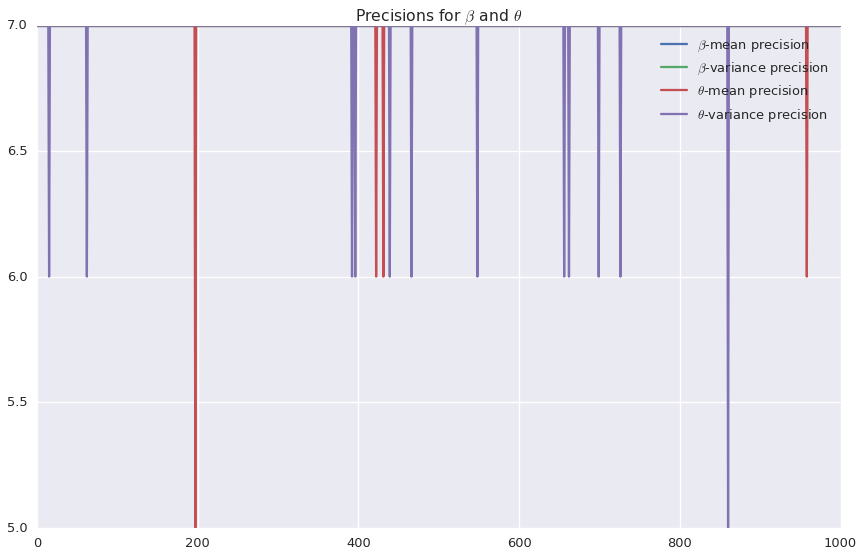

In [9]:
plt.figure(figsize=(9*1.6, 9))
plt.plot(its, [x[0] for x in prec['betas']], label='$\\beta$-mean precision')
plt.plot(its, [x[1] for x in prec['betas']], label='$\\beta$-variance precision')
plt.plot(its, [x[0] for x in prec['thetas']], label='$\\theta$-mean precision')
plt.plot(its, [x[1] for x in prec['thetas']], label='$\\theta$-variance precision')
plt.legend()
plt.title('Precisions for $\\beta$ and $\\theta$')
plt.show()

So, any loss of precision here actually occurs in the inversion of the variance matrix for $\theta$ sampling, since $\Sigma_{\theta}$ is $j \times j$. If we can avoid computing this inverse (or compute the inverse a better way), this can be reduced. Removing/reducing the inversions computed is probably going to be a challenge when $n$ or $j$ gets large. 

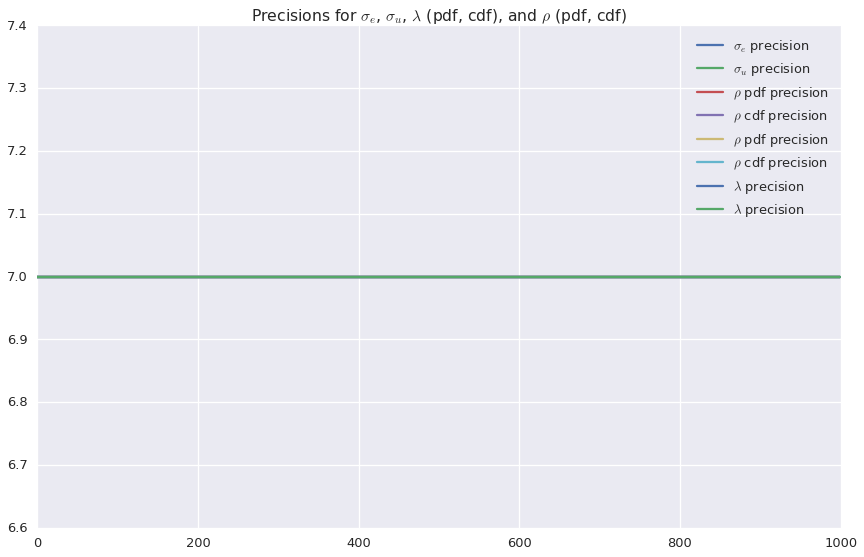

In [10]:
plt.figure(figsize=(1.6*9, 9))
plt.plot(its, prec['sigma_e'], label='$\\sigma_e$ precision')
plt.plot(its, prec['sigma_u'], label='$\\sigma_u$ precision')
plt.plot(its, [x[0] for x in prec['rho']], label='$\\rho$ pdf precision')
plt.plot(its, [x[1] for x in prec['rho']], label='$\\rho$ cdf precision')
plt.plot(its, [x[0] for x in prec['lambda']], label='$\\rho$ pdf precision')
plt.plot(its, [x[1] for x in prec['lambda']], label='$\\rho$ cdf precision')
plt.plot(its, prec['lambda'], label='$\\lambda$ precision')
plt.title('Precisions for $\\sigma_e$, $\\sigma_u$, $\\lambda$ (pdf, cdf), and $\\rho$ (pdf, cdf)')
plt.legend()
plt.show()

Fortunately, all other computations conform out to the maximal precision tested. 

Then, we can look at the plot of the pdfs against which $\rho$ was sampled. We could do this for other parameters as well, but since we're comparing directly the pdfs for $\rho$, we have them laying around anyway. For the other parameters, we'd have to *store* the parameters in each step, not just compare them. That's not something I'm currently doing. 

So, on the top will be $\rho$'s pdf returned from R and on the bottom will be the pdf returned from Python. In addition, I'll provide the mean and variance of the trace. 

Rho Mean: -0.00874825174825, Rho Variance: 0.00293730725219


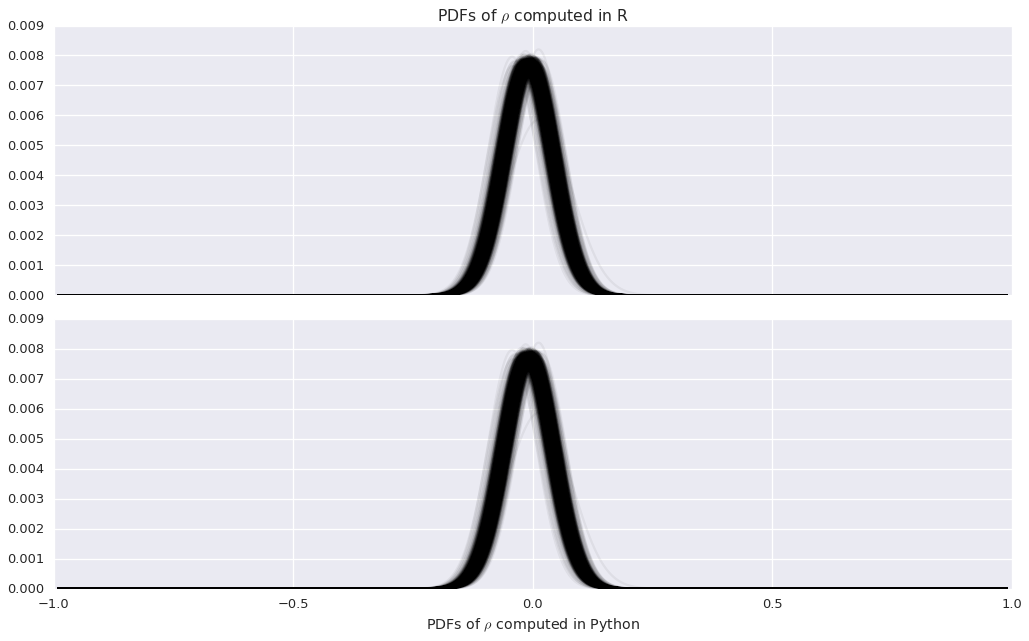

In [11]:
fig,ax = plt.subplots(2,1,sharex=True)
fig.set_figheight(9)
fig.set_figwidth(9*1.6)
for row in pdict['rho']['r']:
    ax[0].plot(R("detval[,1]"), row, 'k', alpha=.05)
    ax[0].set_title('PDFs of $\\rho$ computed in R')
for row in pdict['rho']['py']:
    ax[1].plot(s.trace.Statics['rhos'][:,0].flatten(), row, 'k', alpha=.05)
    ax[1].set_xlabel('PDFs of $\\rho$ computed in Python')
fig.tight_layout()
print('Rho Mean: {}, Rho Variance: {}'.format(np.mean(s.trace.Stochastics['rho']), np.var(s.trace.Stochastics['rho'])))
plt.show()

So, $\rho$ converges quickly and nicely to a value that is very close to the Dong & Harris example runs, where the $\rho$ variance was .05 around a $\rho$ mean of -.01. 

We will also do this for $\lambda$, the upper level SER parameter. 

Lambda Mean: -0.0309430569431, Lambda Variance: 0.0584291905637


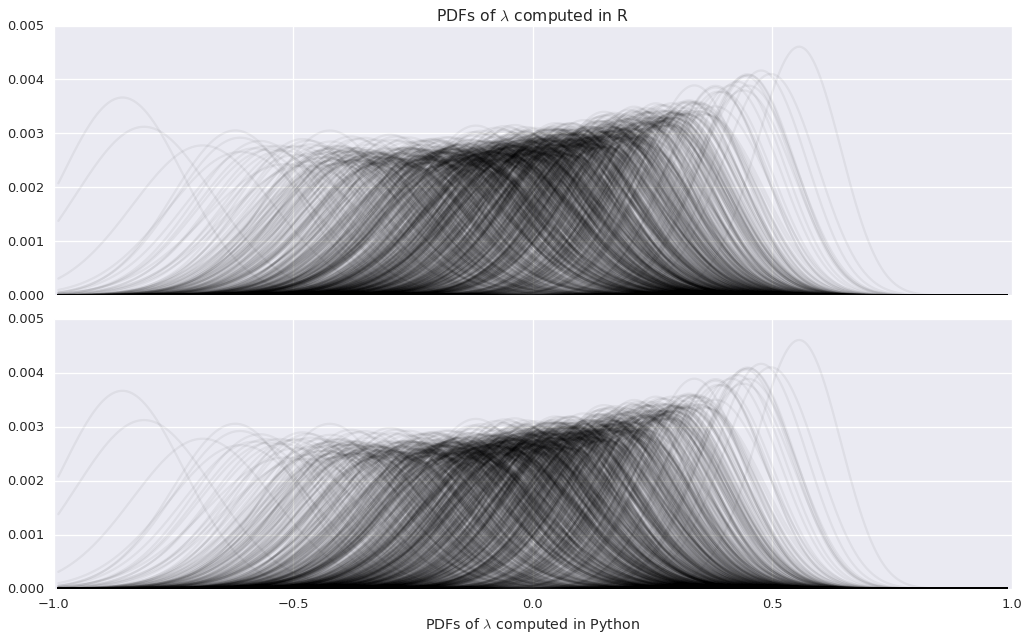

In [12]:
fig,ax = plt.subplots(2,1,sharex=True)
fig.set_figheight(9)
fig.set_figwidth(9*1.6)
for row in pdict['lambda']['r']:
    ax[0].plot(R("detvalM[,1]"), row, 'k', alpha=.05)
    ax[0].set_title('PDFs of $\\lambda$ computed in R')
for row in pdict['lambda']['py']:
    ax[1].plot(s.trace.Statics['lambdas'][:,0].flatten(), row, 'k', alpha=.05)
    ax[1].set_xlabel('PDFs of $\\lambda$ computed in Python')
fig.tight_layout()
print('Lambda Mean: {}, Lambda Variance: {}'.format(np.mean(s.trace.Stochastics['lam']), np.var(s.trace.Stochastics['lam'])))
plt.show()

Again, quite similar to the results Dong & Harris report in `HSARDEMO`, but not exact. In those results, $\lambda$ had a large variance, .2362, and a mean of -.004. Our $\lambda$ is close in value, but the variance is much smaller. 

So, this begs a Monte Carlo validation run or two :)

Also, the following are the traceplots for $\sigma_e$, $\sigma_u$, $\beta$, and $\theta$. 

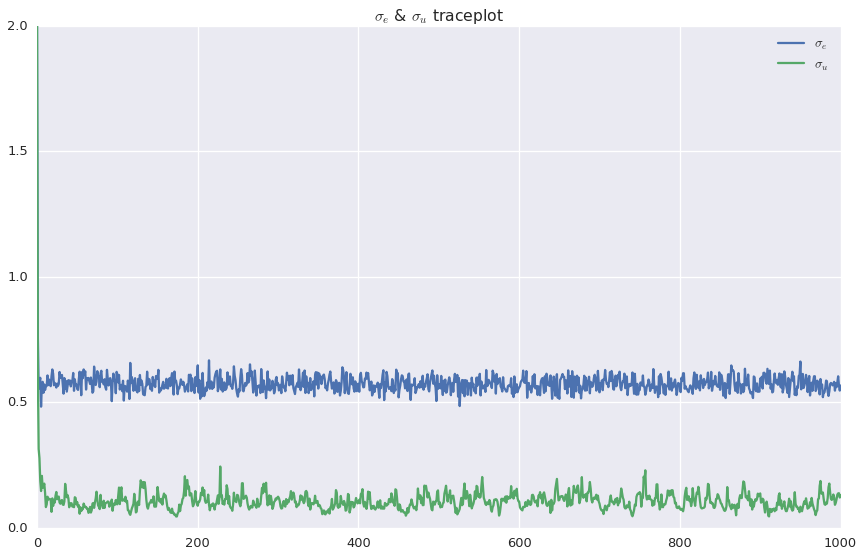

In [13]:
plt.figure(figsize=(9*1.6, 9))
plt.plot(s.trace.Stochastics['sigma_e'], label='$\\sigma_e$')
plt.plot(s.trace.Stochastics['sigma_u'], label='$\\sigma_u$')
plt.legend()
plt.title('$\sigma_e$ & $\sigma_u$ traceplot')

Thus, $\sigma_e$ and $\sigma_u$ match very closely with Dong & Harris's results reported in `HSARDEMO`, where $\sigma_e = .5735$ and $\sigma_u = .1077$. Also of note is that the chain mixes almost immediately, but it looks like $\sigma_u$ is having a slightly slower walk than desirable. 

/home/ljw/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app
/home/ljw/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


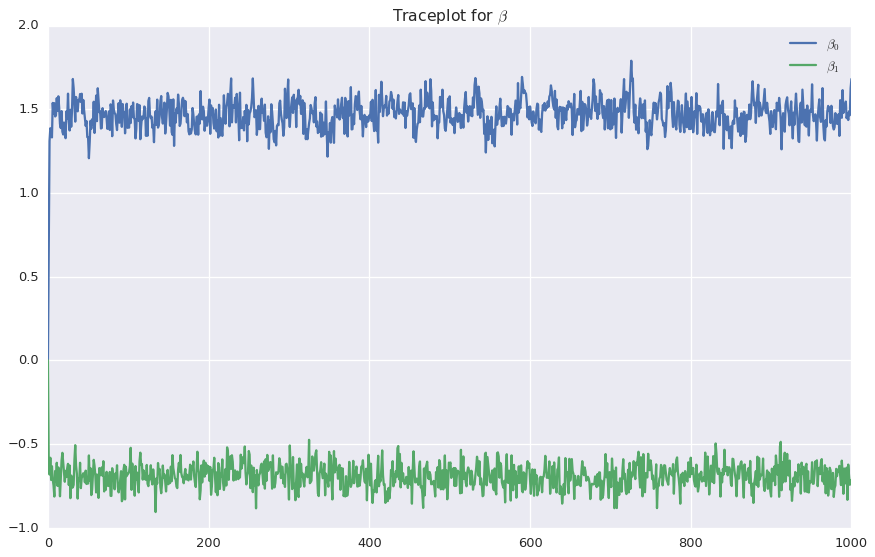

In [14]:
clean = [x for x in s.trace.Stochastics['betas'] if x is not None]
b0 = [x.flatten()[0] for x in clean if None not in x]
b1 = [x.flatten()[1] for x in clean if None not in x]
plt.figure(figsize=(9*1.6, 9))
plt.plot(b0, label='$\\beta_0$')
plt.plot(b1, label='$\\beta_1$')
plt.legend()
plt.title('Traceplot for $\\beta$')

These values are also close to Dong & Harris's values, where their `HSARDEMO` Betas are 1.4720 and -.6916. Fortunately, the chains don't seem to have the small-step problem that it looks like is affecting $\sigma_u$. 

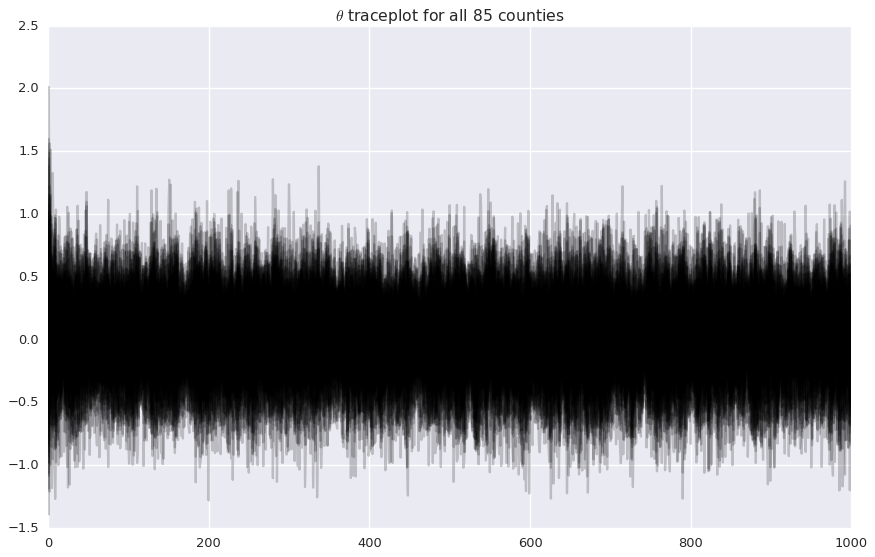

In [15]:
clean = [x for x in s.trace.Stochastics['thetas'][0:-1] if x is not None]
theta_run = np.hstack([x for x in clean])
plt.figure(figsize=(9*1.6, 9))
plt.plot(theta_run.T, 'k', alpha=.2)
plt.title('$\\theta$ traceplot for all 85 counties')
plt.show()

Results aren't reported for the random effects in the `HSARDEMO` script, but I figured I could present them all together. It's very clear the random effects are rather large compared to the rho, but I don't really think this mixes well. The fact that $\lambda$ is all over the place probably drives this. 

Looking at each trace individually, we see that most (if not all) are indistinguishable from zero. 

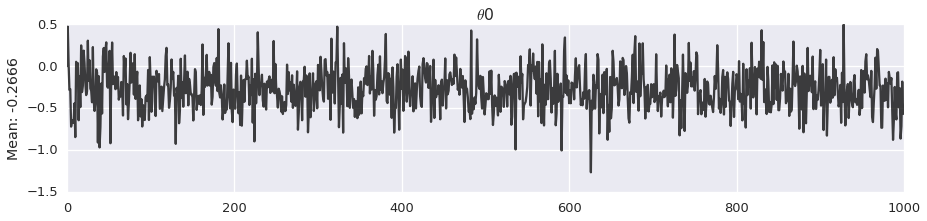

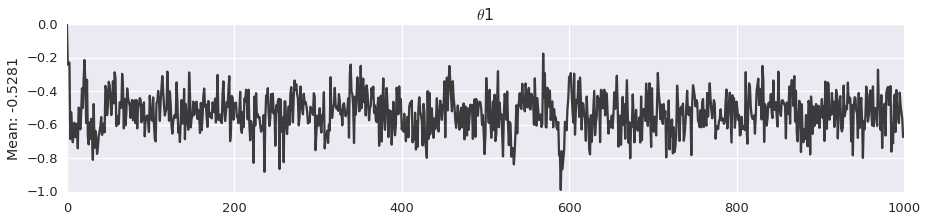

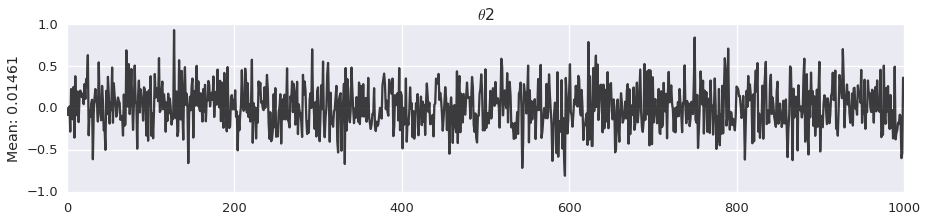

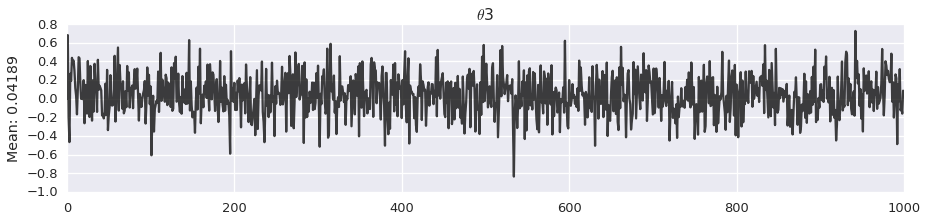

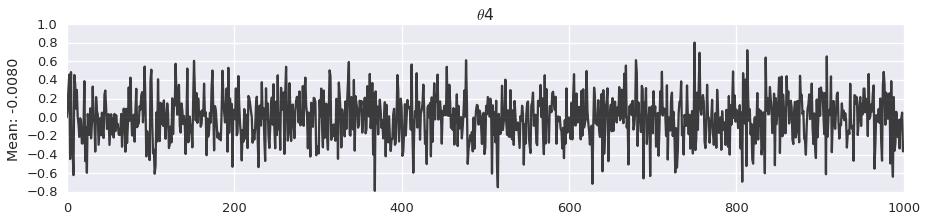

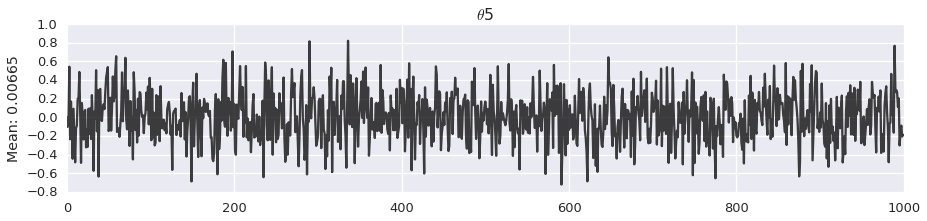

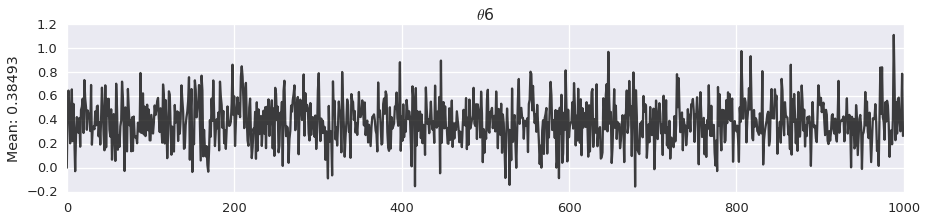

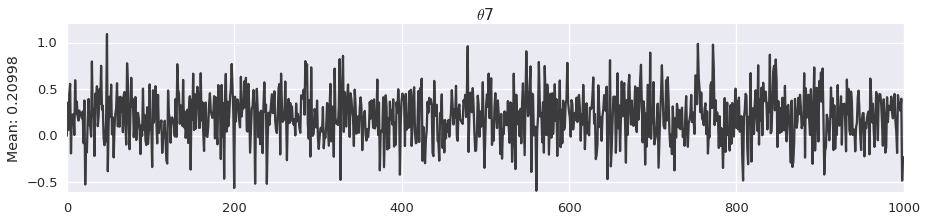

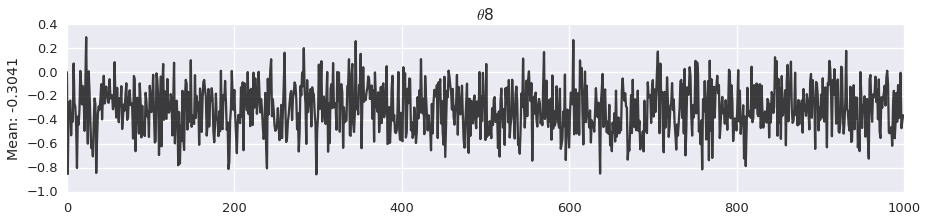

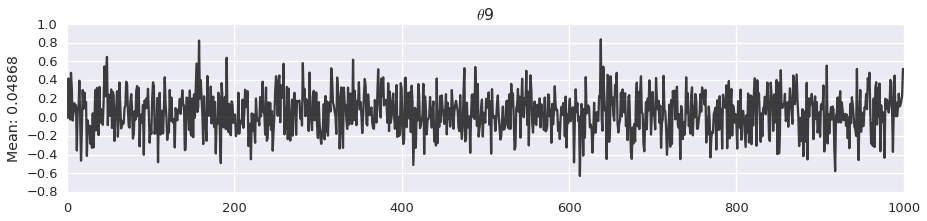

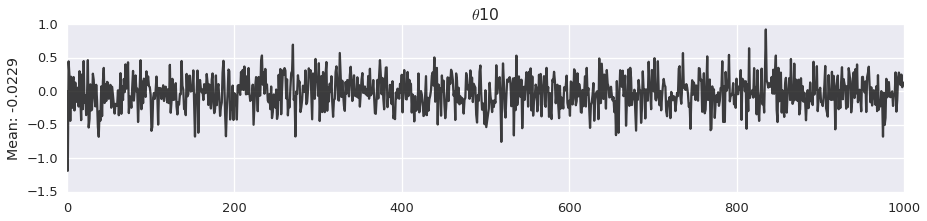

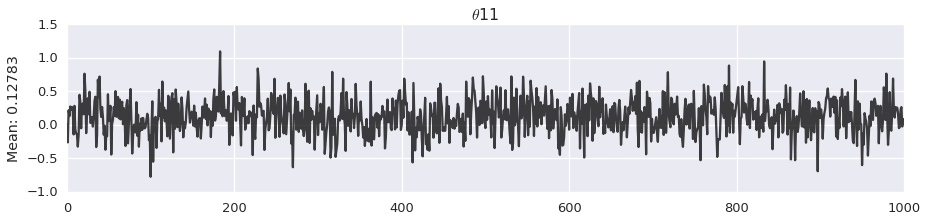

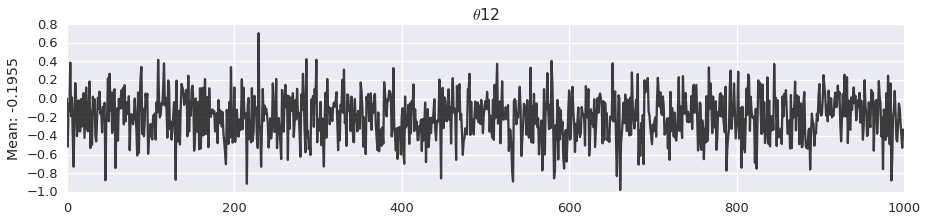

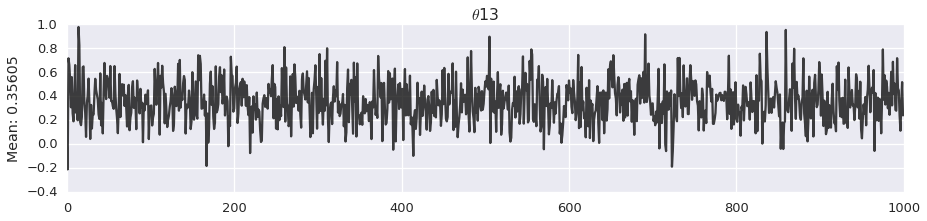

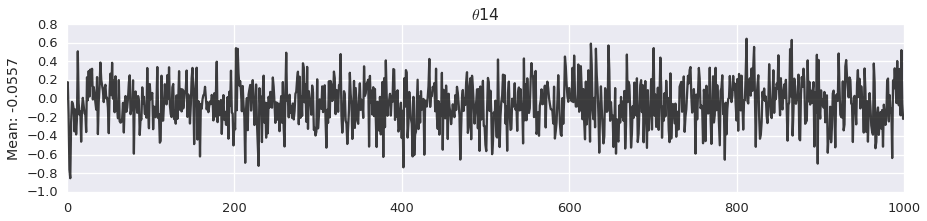

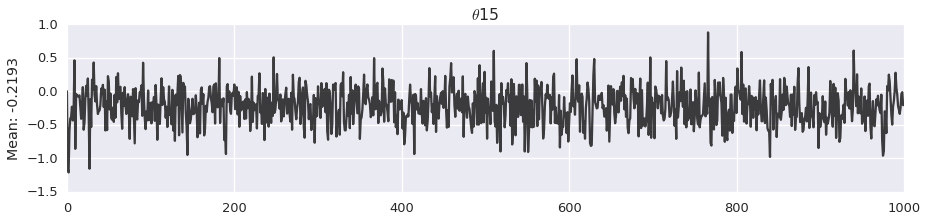

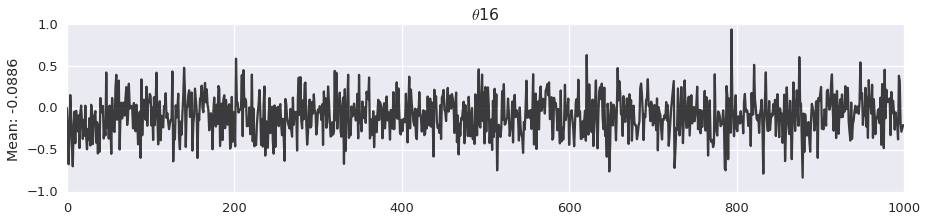

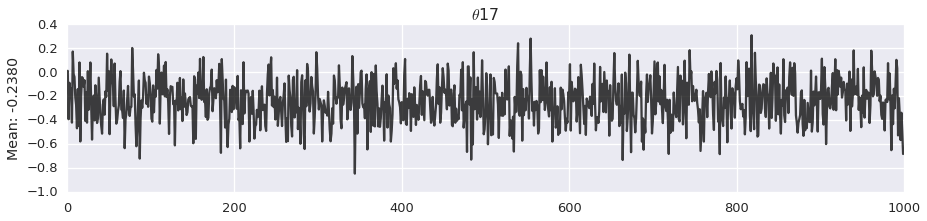

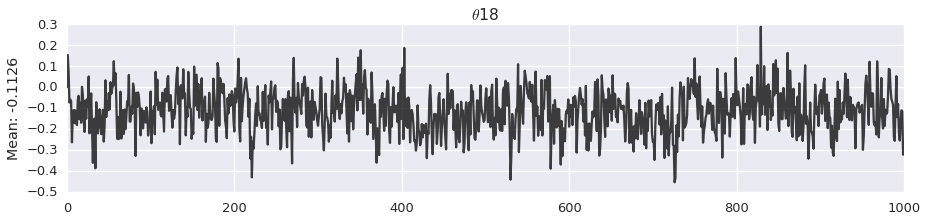

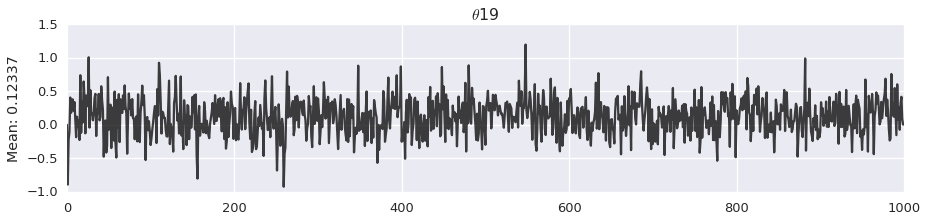

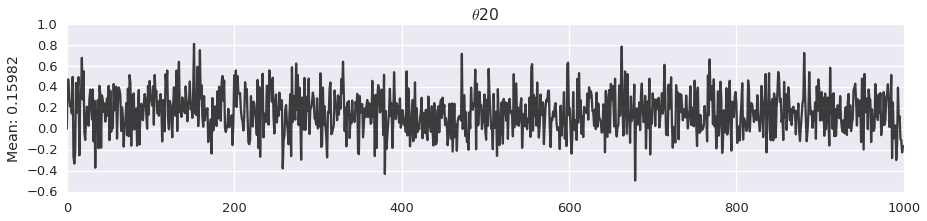

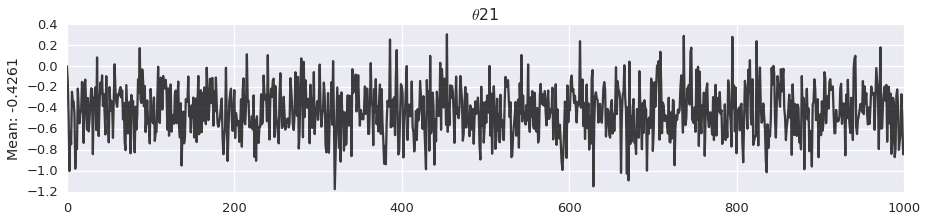

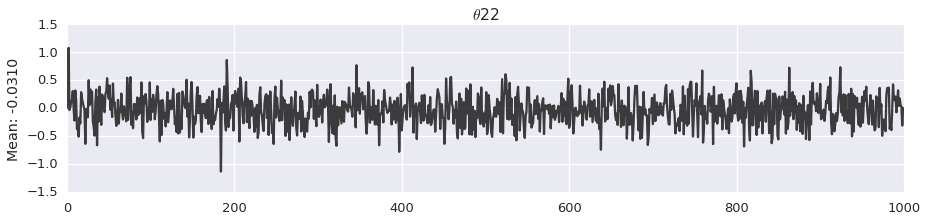

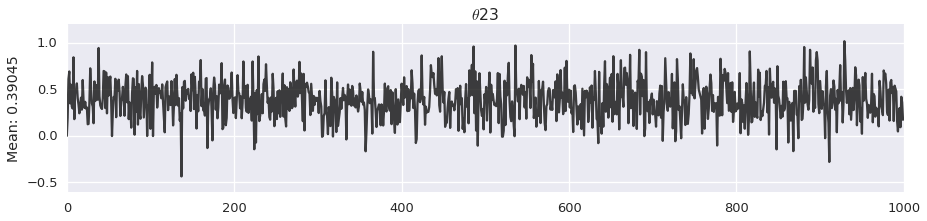

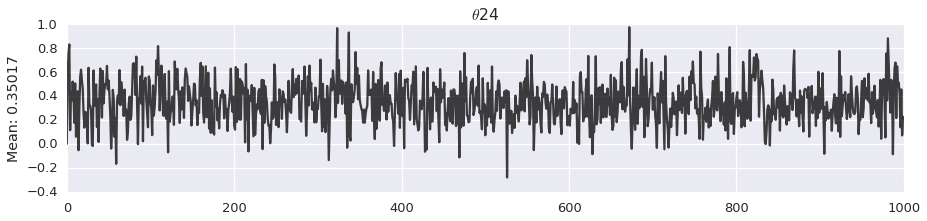

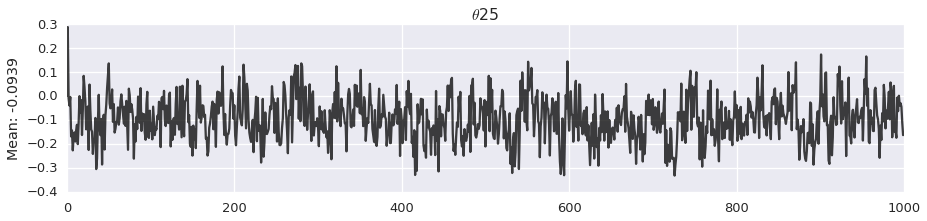

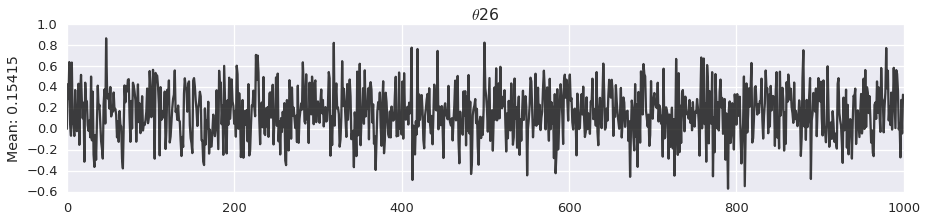

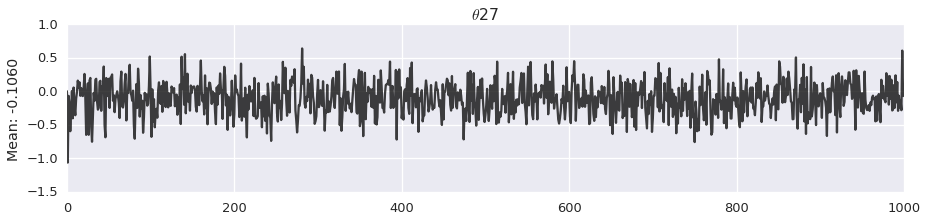

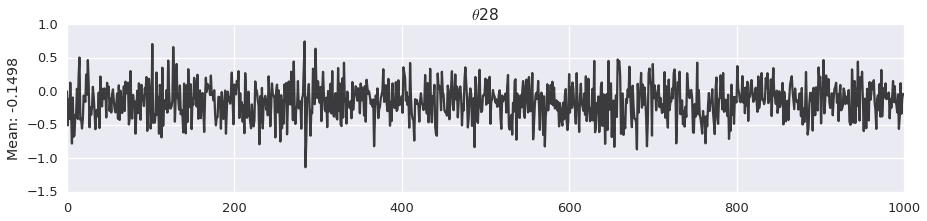

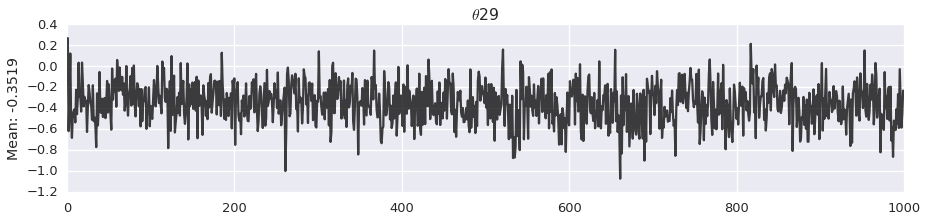

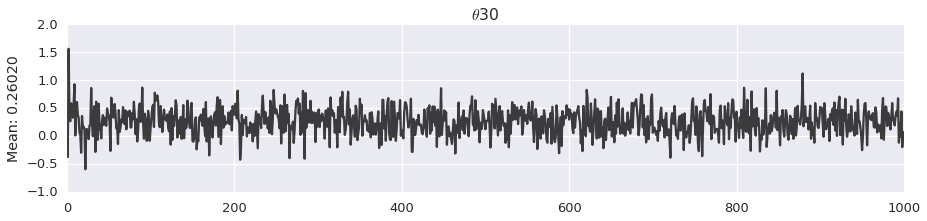

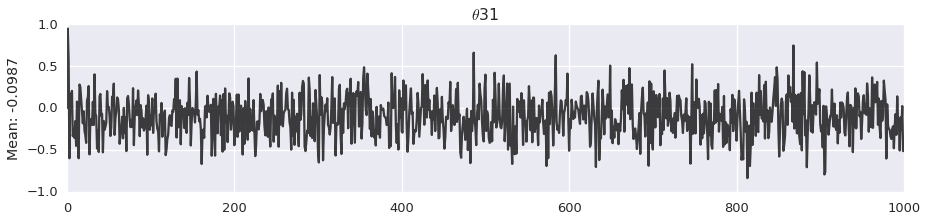

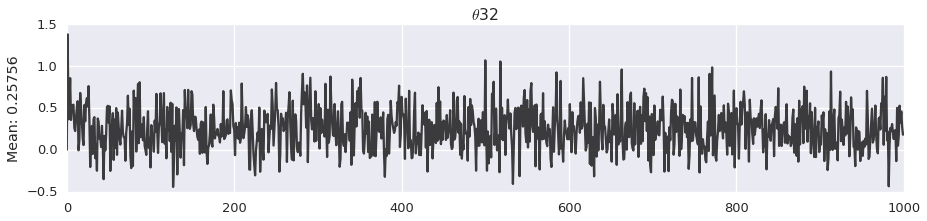

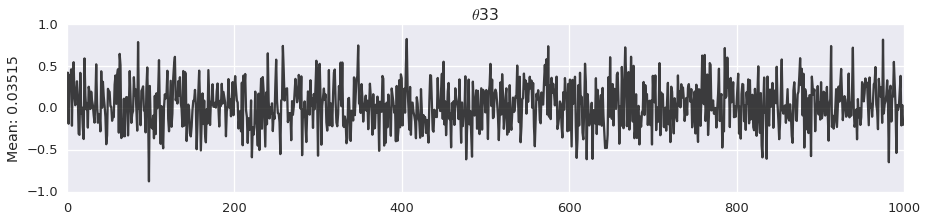

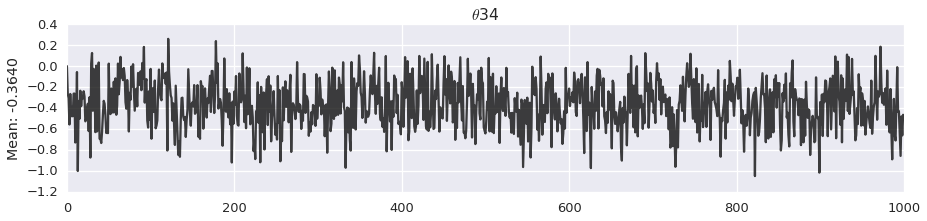

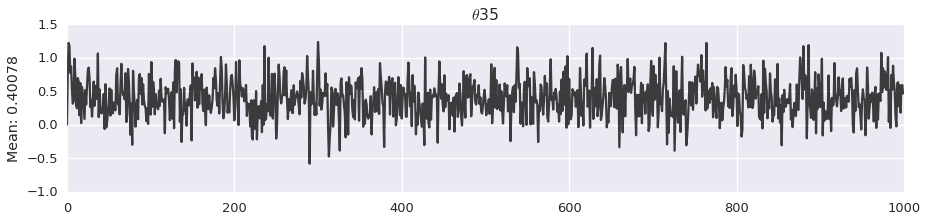

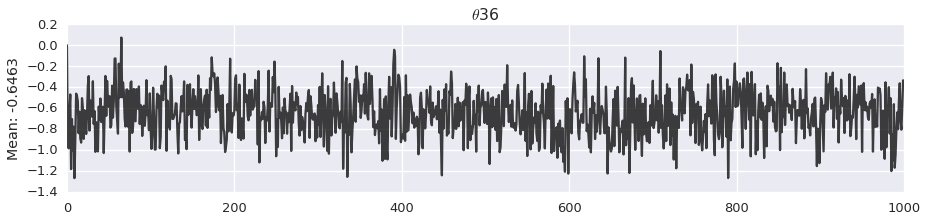

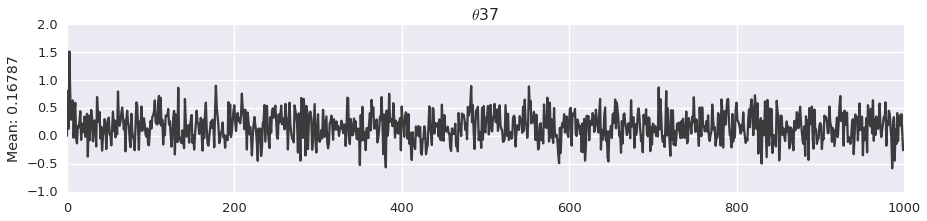

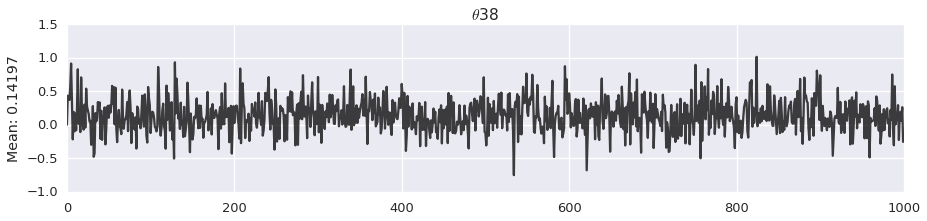

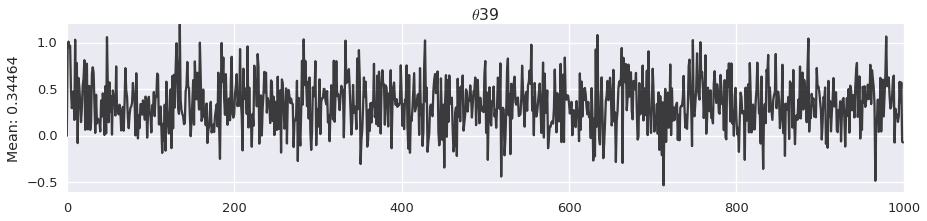

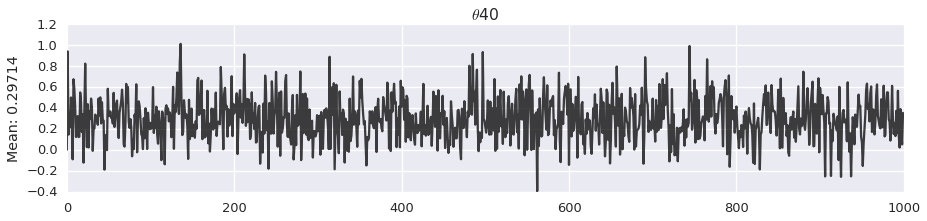

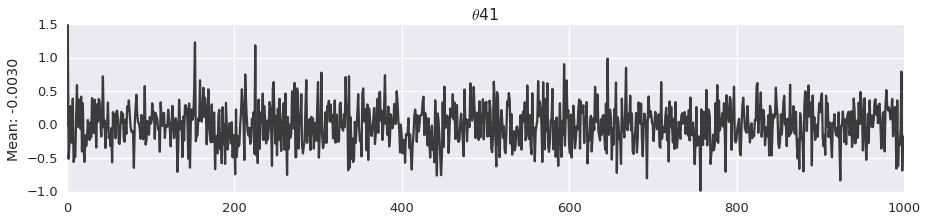

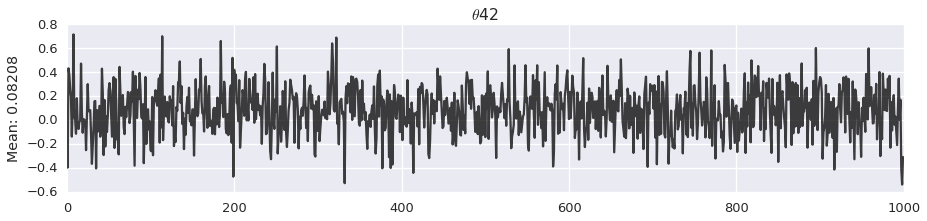

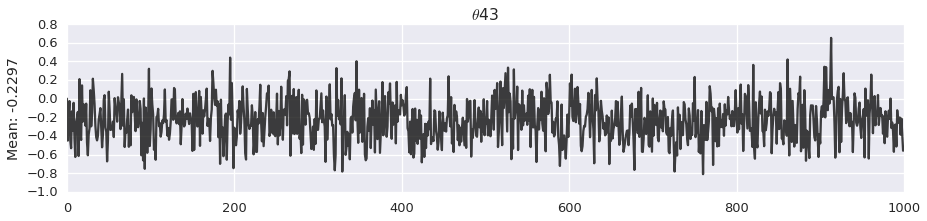

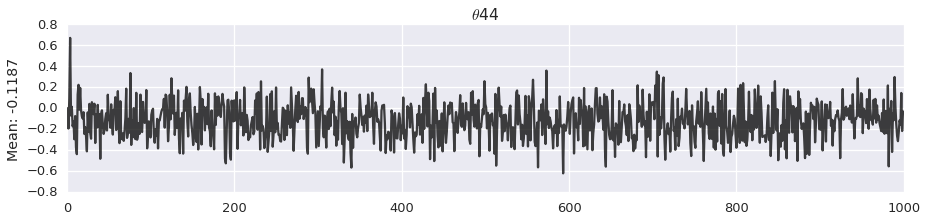

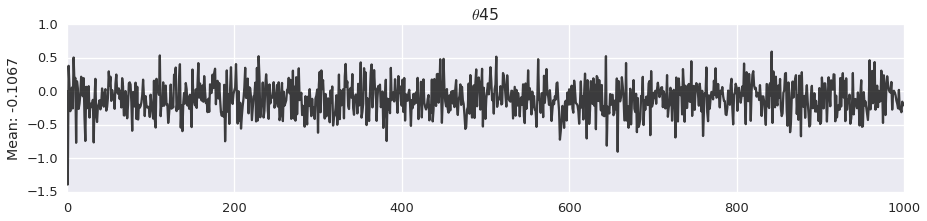

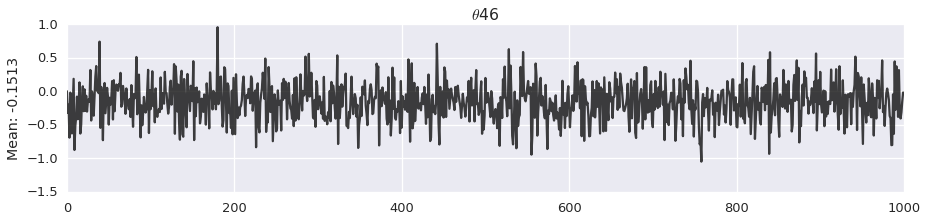

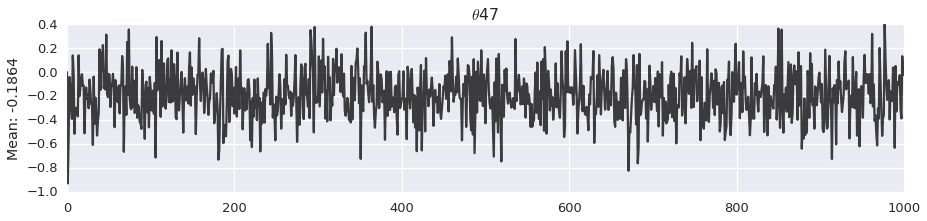

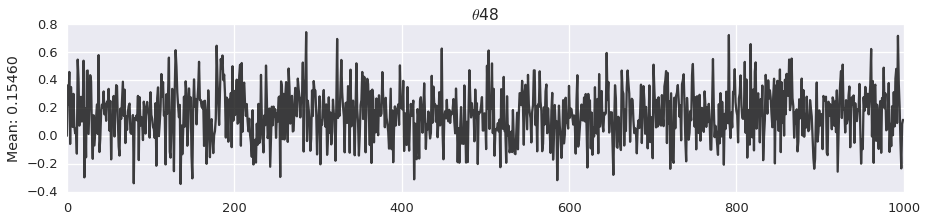

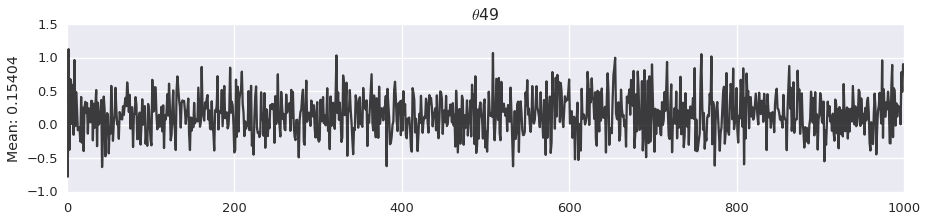

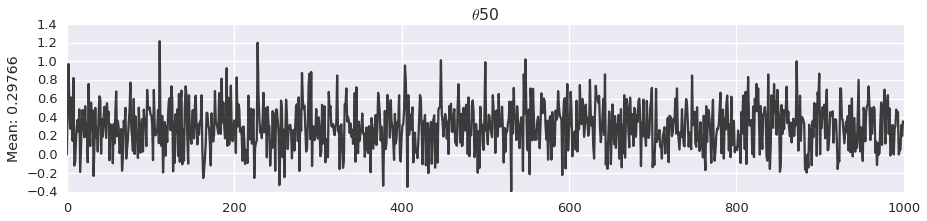

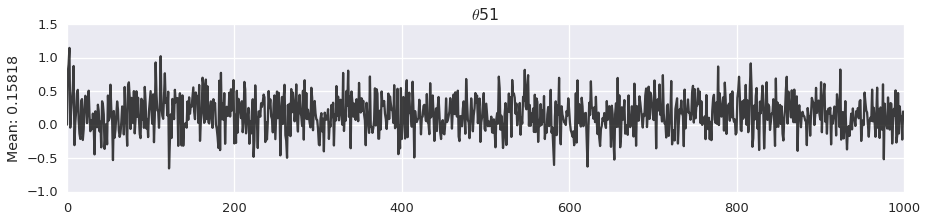

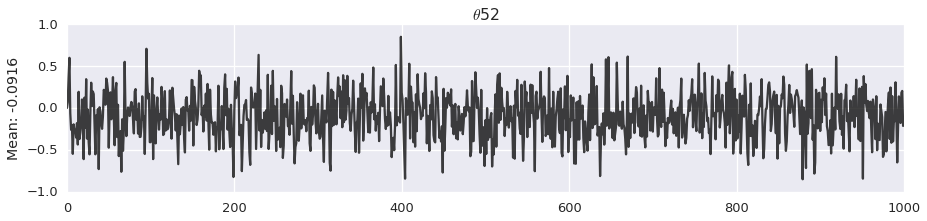

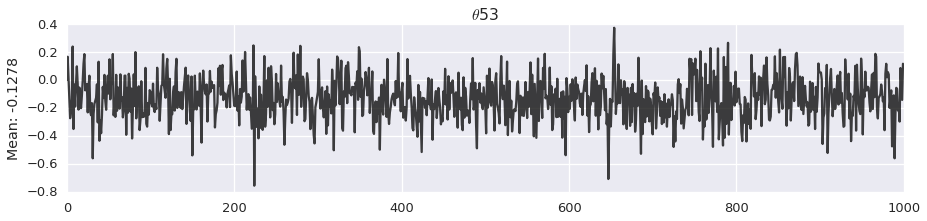

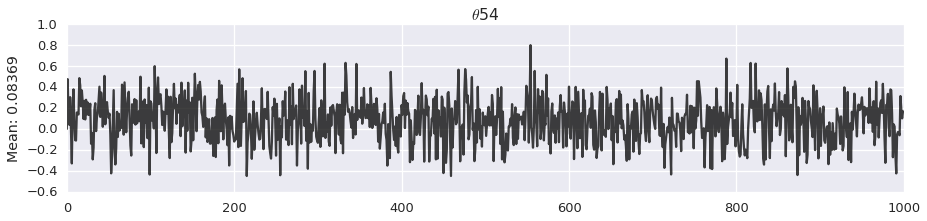

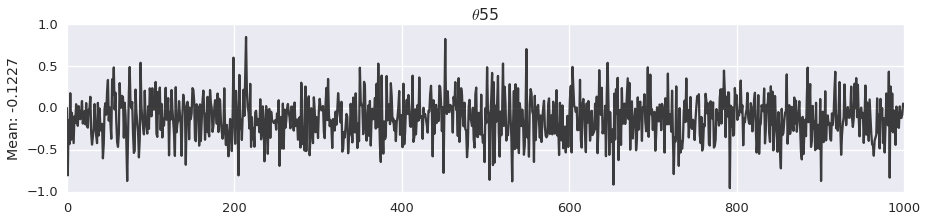

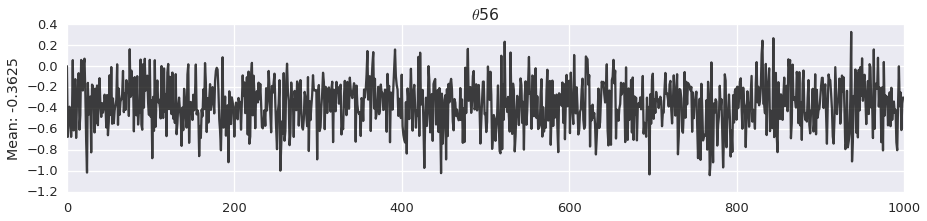

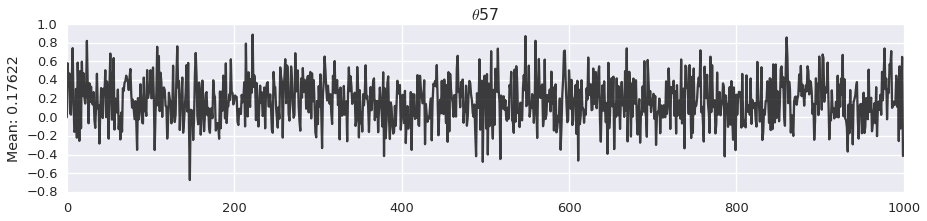

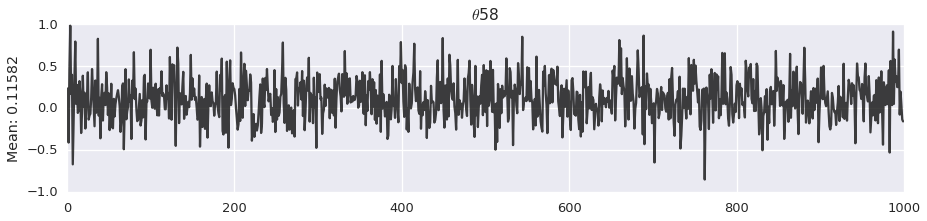

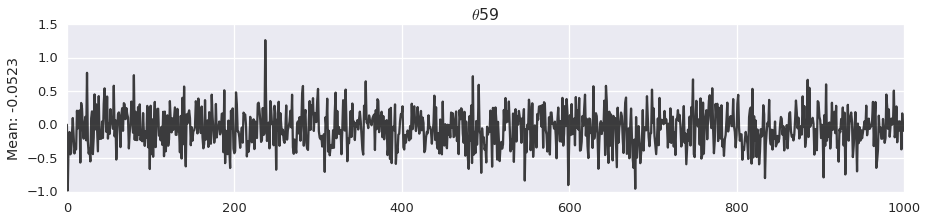

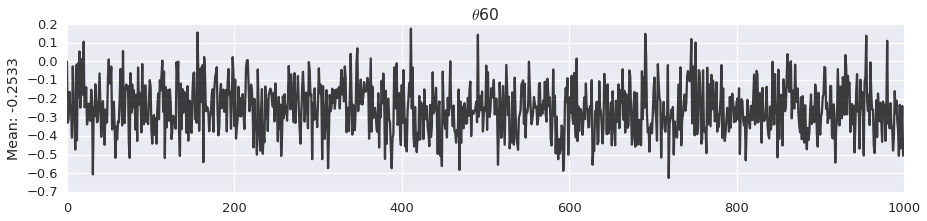

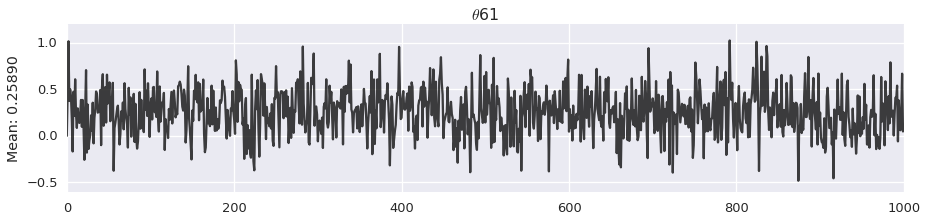

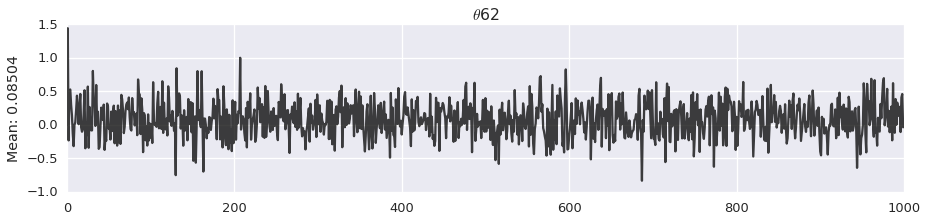

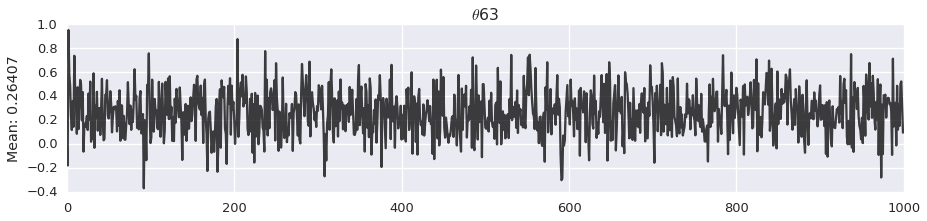

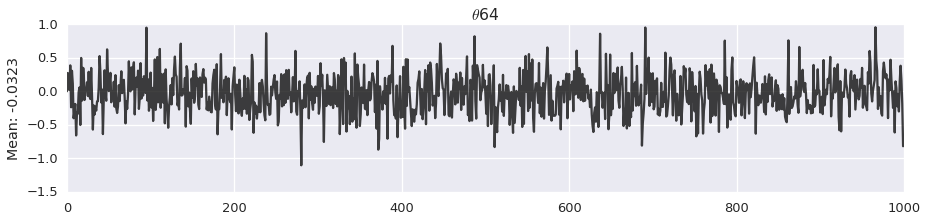

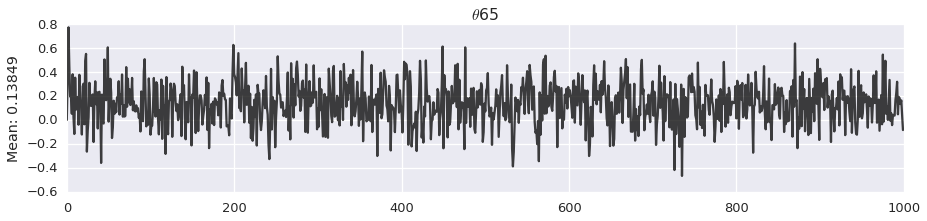

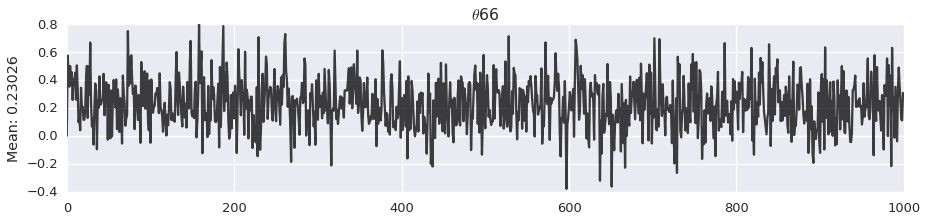

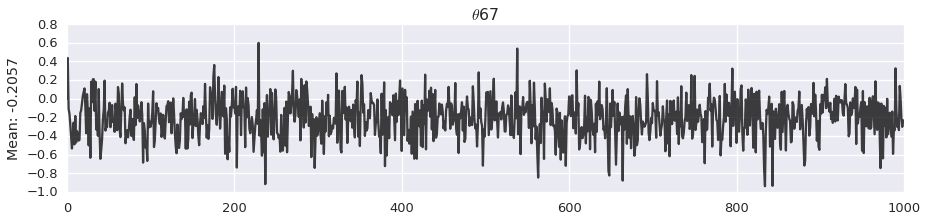

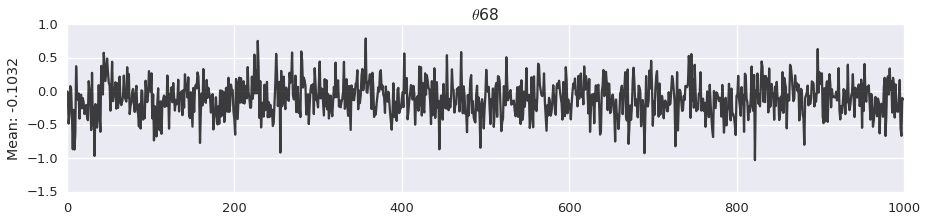

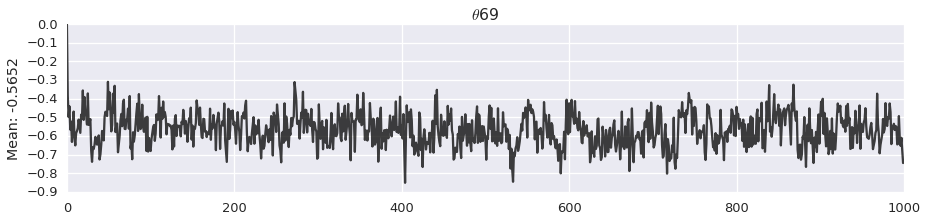

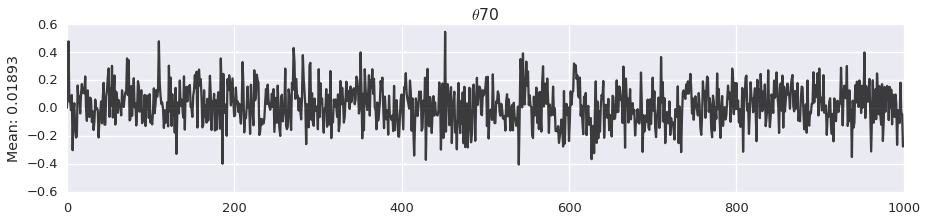

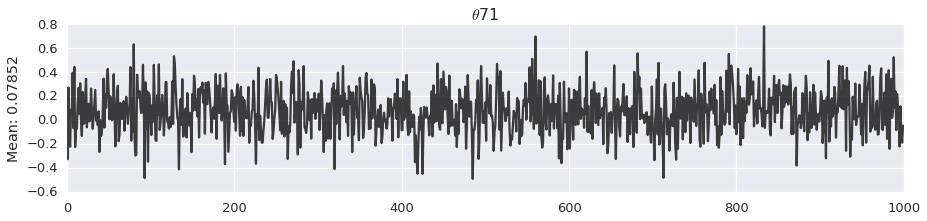

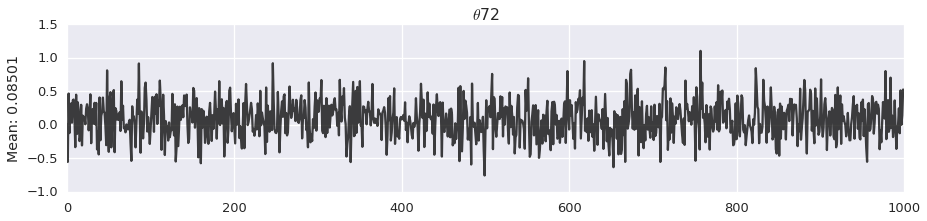

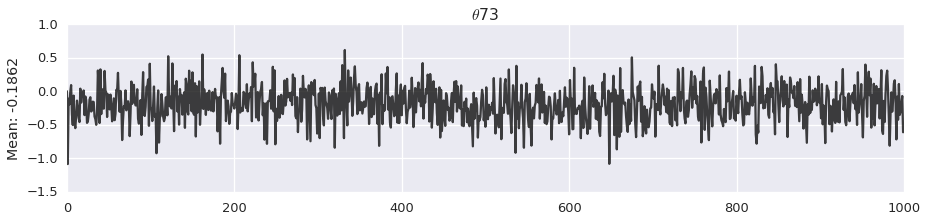

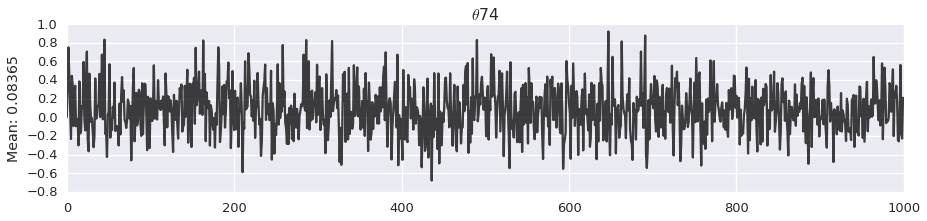

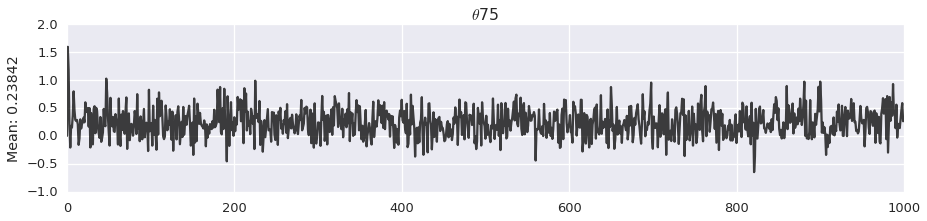

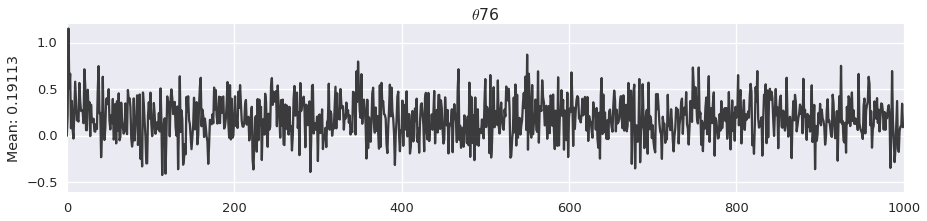

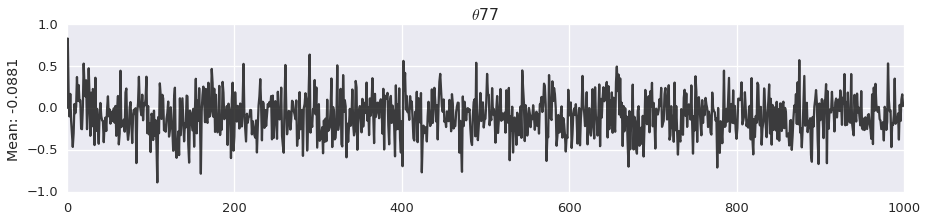

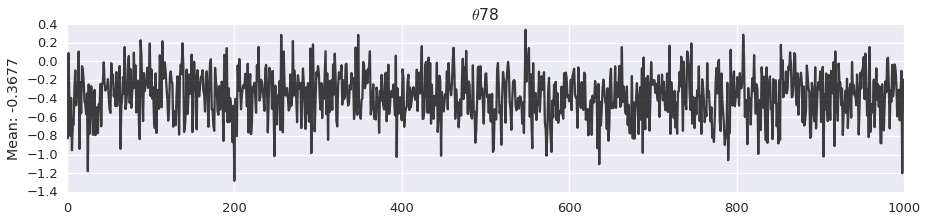

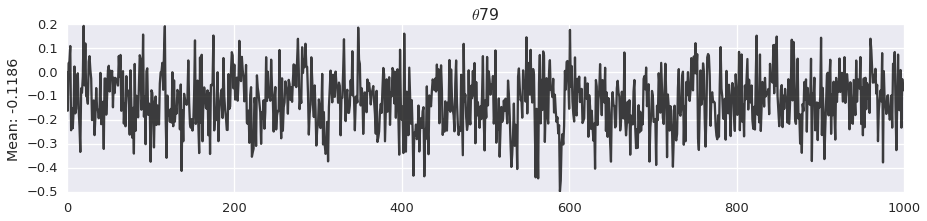

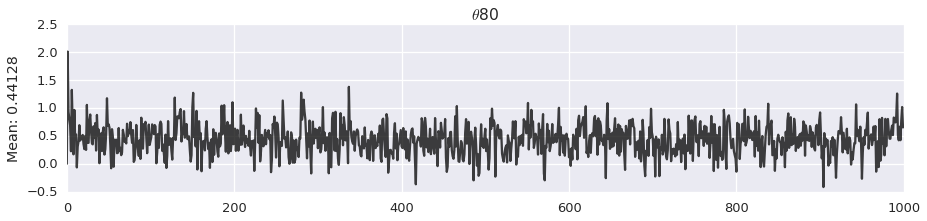

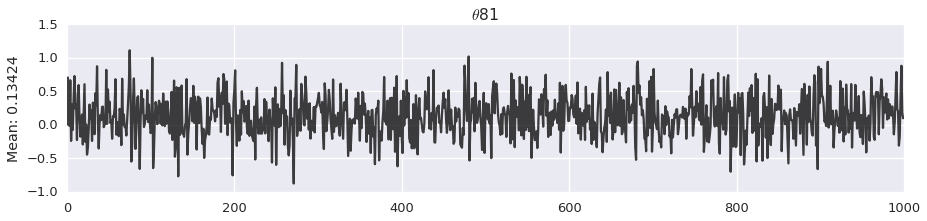

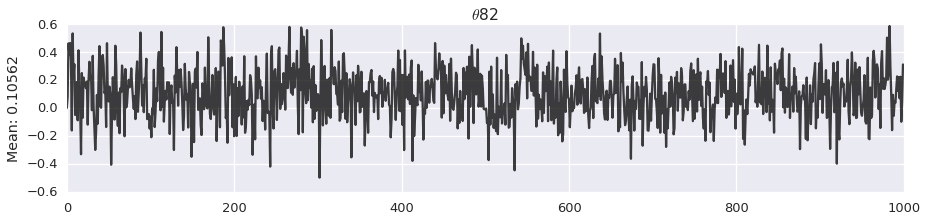

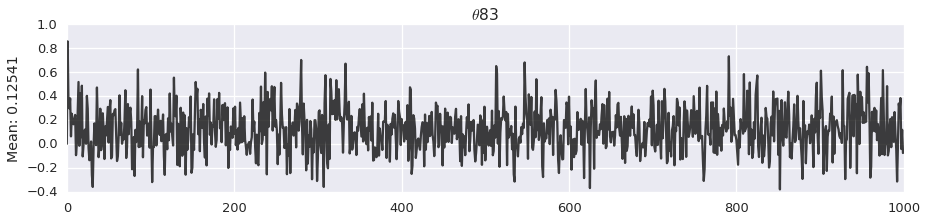

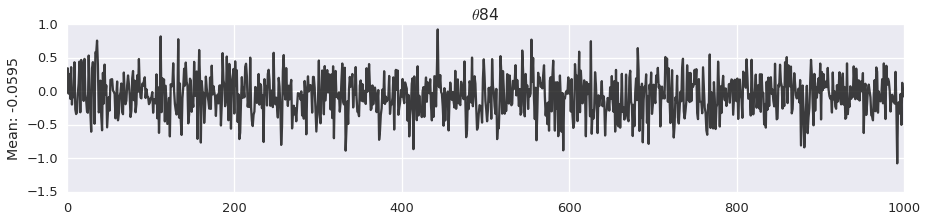

In [30]:
i = 0
for row in theta_run:
    plt.figure(figsize=(15,3))
    plt.plot(range(len(row)), row, 'k', alpha=.75)
    plt.ylabel('Mean: {}'.format(str(np.mean(row))[:7]))
    plt.title("$\\theta${}".format(i))
    i+=1
    plt.show()